<a href="https://colab.research.google.com/github/varun0010/cyclist-detection-and-trajectory-prediction/blob/main/notebooks/TRAJECTORY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install torch numpy matplotlib scikit-learn requests

import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests, zipfile
from io import BytesIO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
 # 1. Download + extract dataset if not already there
# =======================================================
DATASET_URL = "https://zenodo.org/records/5724486/files/dataset.zip?download=1"
dataset_dir = "./APD"

if not os.path.exists(dataset_dir):
    print("Downloading and extracting APD dataset...")
    r = requests.get(DATASET_URL)
    z = zipfile.ZipFile(BytesIO(r.content))
    z.extractall(dataset_dir)
else:
    print("Dataset already exists.")

In [ ]:
# 2. Load cyclist trajectories (simple JSON reader)
# =======================================================
def load_cyclist_data(path):
    trajectories = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".json"):
                with open(os.path.join(root, file), 'r') as f:
                    data = json.load(f)
                if data.get("vru_type") == "bike" and "head_smoothed" in data:
                    coords = []
                    for pt in data["head_smoothed"]:
                        if pt is None or any(x is None for x in pt):
                            coords.append([np.nan, np.nan])
                        else:
                            coords.append([pt[0], pt[1]])
                    coords = np.array(coords)
                    if np.isnan(coords).sum() < len(coords)*2*0.2:
                        trajectories.append(coords)
    return trajectories

print("Loading trajectories...")
trajectories = load_cyclist_data(dataset_dir)
print(f"Loaded {len(trajectories)} raw trajectories")

Loading trajectories...
Loaded 1734 raw trajectories


In [ ]:
# =======================================================
# 3. Preprocessing: fill NaNs & normalize
# =======================================================
def preprocess_trajectory(traj):
    for dim in range(traj.shape[1]):
        valid = ~np.isnan(traj[:, dim])
        if valid.sum() < 2:
            return None
        traj[:, dim] = np.interp(np.arange(len(traj)), np.where(valid)[0], traj[valid, dim])
    traj -= traj.mean(0)
    traj /= (traj.std(0) + 1e-6)
    return traj

trajectories = [preprocess_trajectory(t) for t in trajectories]
trajectories = [t for t in trajectories if t is not None]
print(f"After preprocessing: {len(trajectories)}")

After preprocessing: 1734


In [ ]:
# 4. Sequence creation
# =======================================================
OBS_LEN = 8
PRED_LEN = 12
SEQ_LEN = OBS_LEN + PRED_LEN

def create_sequences(trajs):
    seqs = []
    for t in trajs:
        if len(t) >= SEQ_LEN:
            for i in range(len(t)-SEQ_LEN+1):
                seqs.append(t[i:i+SEQ_LEN])
    return np.array(seqs)

seqs = create_sequences(trajectories)
print(f"Total sequences: {len(seqs)}")

Total sequences: 544134


In [ ]:
# 5. Train/Val/Test split (70/15/15)
# =======================================================
train_seqs, temp_seqs = train_test_split(seqs, test_size=0.3, random_state=42)
val_seqs, test_seqs = train_test_split(temp_seqs, test_size=0.5, random_state=42)

class TrajectoryDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs
    def __len__(self): return len(self.seqs)
    def __getitem__(self, idx):
        s = self.seqs[idx]
        return torch.FloatTensor(s[:OBS_LEN]), torch.FloatTensor(s[OBS_LEN:])

train_loader = DataLoader(TrajectoryDataset(train_seqs), batch_size=64, shuffle=True)
val_loader = DataLoader(TrajectoryDataset(val_seqs), batch_size=64)
test_loader = DataLoader(TrajectoryDataset(test_seqs), batch_size=64)

In [ ]:
# 6. Normal LSTM Model (single LSTM block, no encoder-decoder)
# =======================================================
class NormalLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, obs):
        # Encode observed trajectory
        _, (h, c) = self.lstm(obs)
        decoder_input = obs[:, -1, :]  # last observed point
        outputs = []
        hidden = (h, c)  # reuse hidden state
        for _ in range(PRED_LEN):
            out, hidden = self.lstm(decoder_input.unsqueeze(1), hidden)
            pred_pos = self.fc(out.squeeze(1))
            outputs.append(pred_pos)
            decoder_input = pred_pos
        return torch.stack(outputs, dim=1)

In [ ]:
# 7. Train/Eval functions
# =======================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NormalLSTM().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

def run_epoch(loader, training=True):
    total_loss = 0
    if training: model.train()
    else: model.eval()
    for obs, fut in loader:
        obs, fut = obs.to(device), fut.to(device)
        if training: opt.zero_grad()
        pred = model(obs)
        loss = loss_fn(pred, fut)
        if training:
            loss.backward()
            opt.step()
        total_loss += loss.item() * obs.size(0)
    return total_loss / len(loader.dataset)

In [ ]:
# 8. Training loop
# =======================================================
for epoch in range(1, 21):
    train_loss = run_epoch(train_loader, True)
    val_loss = run_epoch(val_loader, False)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 01 | Train Loss: 0.0277 | Val Loss: 0.0171
Epoch 02 | Train Loss: 0.0149 | Val Loss: 0.0119
Epoch 03 | Train Loss: 0.0124 | Val Loss: 0.0127
Epoch 04 | Train Loss: 0.0114 | Val Loss: 0.0102
Epoch 05 | Train Loss: 0.0107 | Val Loss: 0.0101
Epoch 06 | Train Loss: 0.0101 | Val Loss: 0.0095
Epoch 07 | Train Loss: 0.0098 | Val Loss: 0.0093
Epoch 08 | Train Loss: 0.0094 | Val Loss: 0.0107
Epoch 09 | Train Loss: 0.0092 | Val Loss: 0.0090
Epoch 10 | Train Loss: 0.0090 | Val Loss: 0.0086
Epoch 11 | Train Loss: 0.0087 | Val Loss: 0.0080
Epoch 12 | Train Loss: 0.0085 | Val Loss: 0.0083
Epoch 13 | Train Loss: 0.0083 | Val Loss: 0.0084
Epoch 14 | Train Loss: 0.0082 | Val Loss: 0.0086
Epoch 15 | Train Loss: 0.0079 | Val Loss: 0.0082
Epoch 16 | Train Loss: 0.0078 | Val Loss: 0.0080
Epoch 17 | Train Loss: 0.0077 | Val Loss: 0.0074
Epoch 18 | Train Loss: 0.0075 | Val Loss: 0.0076
Epoch 19 | Train Loss: 0.0074 | Val Loss: 0.0073
Epoch 20 | Train Loss: 0.0073 | Val Loss: 0.0072


In [ ]:
# 9. Test evaluation
# =======================================================
test_loss = run_epoch(test_loader, False)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0070


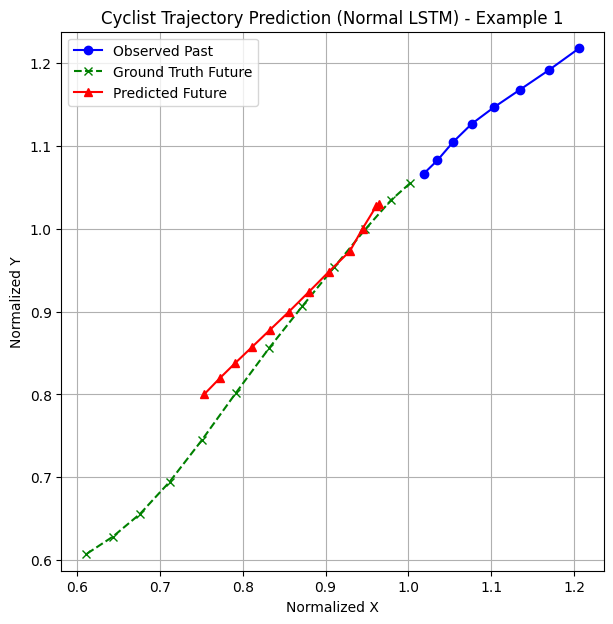

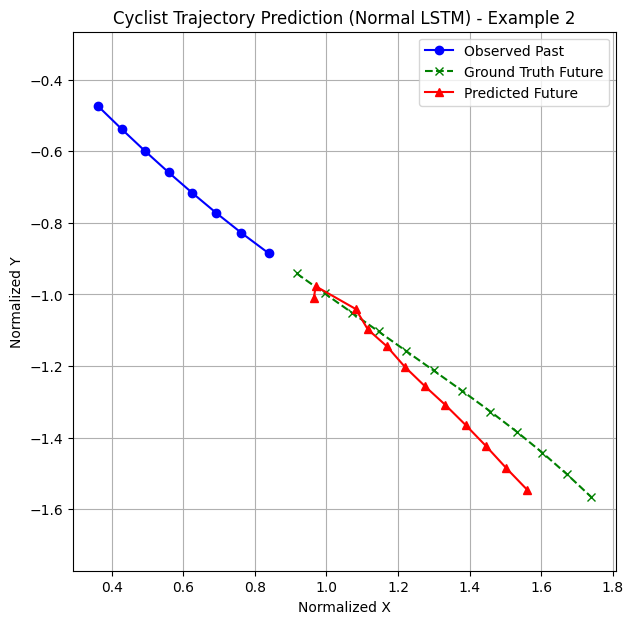

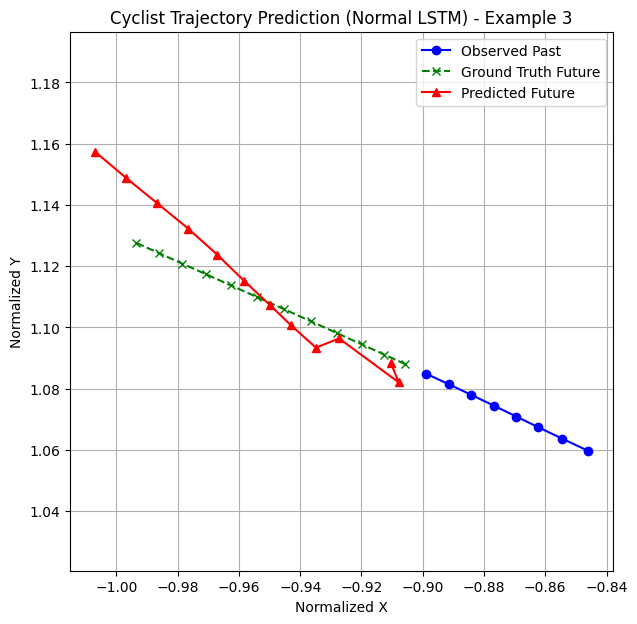

In [ ]:
# 10. Plot examples
# =======================================================
model.eval()
with torch.no_grad():
    num_examples_to_plot = 3  # Change this to plot more or fewer examples
    for i in range(num_examples_to_plot):
        obs, fut = next(iter(test_loader))
        obs, fut = obs[i:i+1].to(device), fut[i:i+1]
        pred = model(obs).cpu().numpy()[0]
        obs = obs.cpu().numpy()[0]
        fut = fut.cpu().numpy()[0]


        plt.figure(figsize=(7,7))
        plt.grid(True)
        plt.plot(obs[:,0], obs[:,1], 'bo-', label="Observed Past")
        plt.plot(fut[:,0], fut[:,1], 'gx--', label="Ground Truth Future")
        plt.plot(pred[:,0], pred[:,1], 'r^-', label="Predicted Future")
        plt.axis('equal')
        plt.legend()
        plt.title(f"Cyclist Trajectory Prediction (Normal LSTM) - Example {i+1}")
        plt.xlabel("Normalized X")
        plt.ylabel("Normalized Y")
        plt.show()

In [ ]:
# 11. Save the trained model
# =======================================================
model_save_path = "normal_lstm_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to normal_lstm_model.pth


In [ ]:
from google.colab import files

files.download('normal_lstm_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>